In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm

In [ ]:
def pdf_1(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

def pdf_2(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

In [4]:
from scipy.integrate import simps

def compute_analytic_JSD(mean1, var1, mean2, var2):
    xmin = min(mean1 - 5 * np.sqrt(var1), mean2 - 5 * np.sqrt(var2))
    xmax = max(mean1 + 5 * np.sqrt(var1), mean2 + 5 * np.sqrt(var2))
    x_grid = np.linspace(xmin, xmax, 1000000)
    pdf1 = pdf_1(x_grid, mean1, var1)
    pdf2 = pdf_2(x_grid, mean2, var2)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

def compute_analytic_JSD_2(f1, f2):
    x_grid = np.linspace(-10., 10., 1000000)
    pdf1 = f1(x_grid)
    pdf2 = f2(x_grid)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

def generate_data_1(mean_1, var_1, N):
    return np.random.normal(mean_1, np.sqrt(var_1), N)

def generate_data_2(mean_2, var_2, N):
    return np.random.normal(mean_2, np.sqrt(var_2), N)

def compute_JSD(result1, result2, interpolation='quadratic', binning="FD"):    
    if binning == "FD":
        number_of_bins_1 = int((result1.max() - result1.min())/(2*iqr(result1)*result1.size**(-1/3)))
    elif binning == "S":
        number_of_bins_1 = int(1 + np.log2(result1.size))
    elif binning == "fuckit50":
        number_of_bins_1 = 50
    if number_of_bins_1 < 5:
        number_of_bins_1 = 5
    nbins1 = np.linspace(result1.min(), result1.max(), number_of_bins_1)

    if binning == "FD":
        number_of_bins_2 = int((result2.max() - result2.min())/(2*iqr(result2)*result2.size**(-1/3)))
    elif binning == "S":
        number_of_bins_2 = int(1 + np.log2(result2.size))
    elif binning == "fuckit50":
        number_of_bins_2 = 50
    if number_of_bins_2 < 5:
        number_of_bins_2 = 5
    nbins2 = np.linspace(result2.min(), result2.max(), number_of_bins_2)
    h, bins = np.histogram(
        result1, density=True, bins=nbins1
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])

    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)

    h, bins = np.histogram(
        result2, density=True, bins=nbins2
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)
    x_grid = np.linspace(min(min1, min2), max(max1, max2), 1000)

    def fit_1(x):
        return max(1e-10, fit1(x))

    def fit_2(x):
        return max(1e-10, fit2(x))


    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)

    JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid))**2
    return JSD, fit_1, fit_2

In [49]:
mean_1, var_1 = 0., 1.
mean_2, var_2 = 0., 1.
N = 5000

In [50]:
N_samples = 200
N_points = 100
var_start = 5**2
var_end = 1.01**2
var_factor = np.exp(np.log(var_end/var_start)/(N_points-1))
var_list = np.array([var_start*var_factor**i for i in range(N_points)])
true_jsds = np.zeros((N_points))
estimated_jsds = np.zeros((N_points, N_samples))

In [51]:
for i, variance in tqdm(enumerate(var_list)):
    true_jsd = compute_analytic_JSD(mean_1, 1.0, mean_2, variance)
    for j in range(N_samples):
        result1 = generate_data_1(mean_1, 1.0, N)
        result2 = generate_data_2(mean_2, variance, N)
        JSD, fit_1, fit_2 = compute_JSD(result1, result2)
        estimated_jsds[i, j] = JSD
    true_jsds[i] = true_jsd

100it [08:03,  4.84s/it]


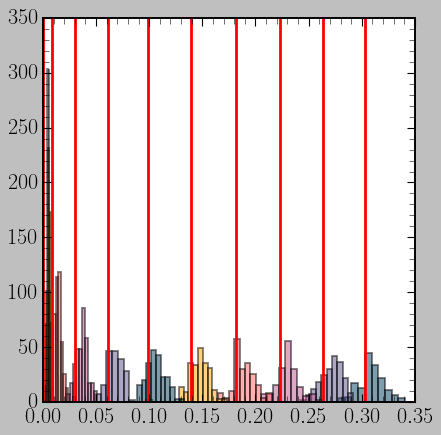

In [26]:
for i in range(N_points):
    plt.hist(estimated_jsds[i,:], bins=10, density=True, alpha=0.5)
    plt.axvline(true_jsds[i], color='red')
plt.show()

Text(0.5, 1.0, 'N = 1000')

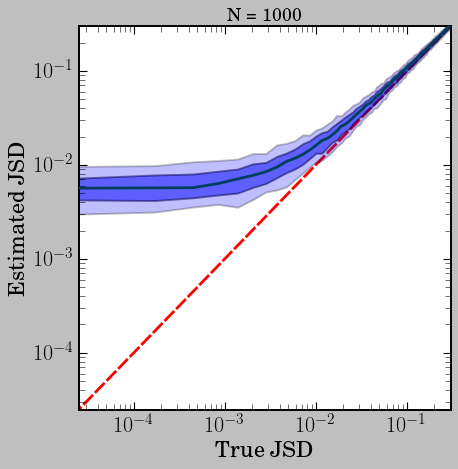

In [41]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 1000')

Text(0.5, 1.0, 'N = 10000')

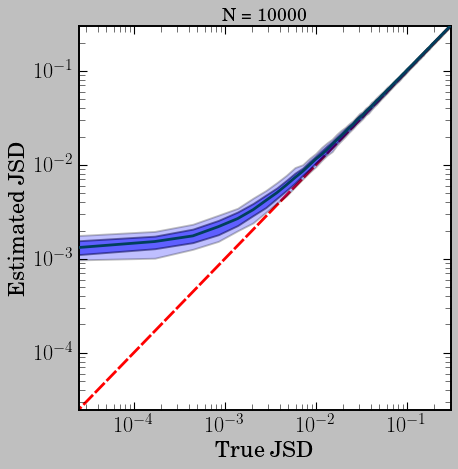

In [45]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 10000')

Text(0.5, 1.0, 'N = 10000')

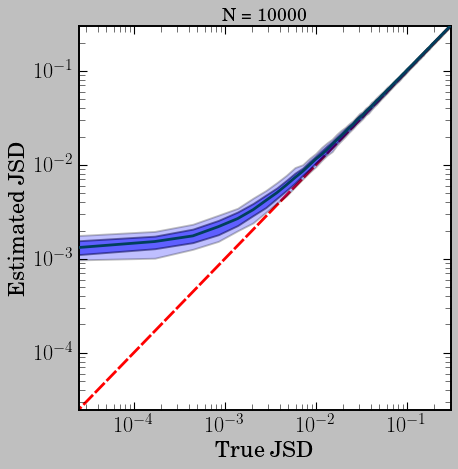

In [48]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 10000')

Text(0.5, 1.0, 'N = 5000')

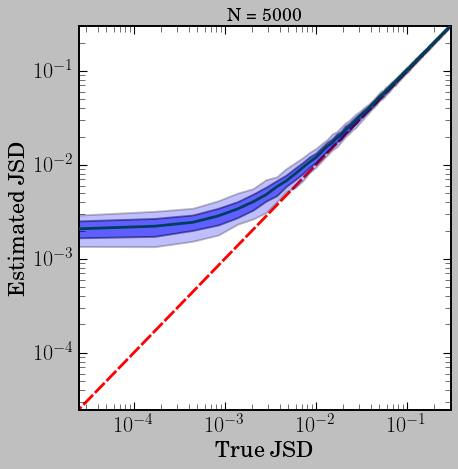

In [52]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')

Text(0.5, 1.0, 'N = 5000')

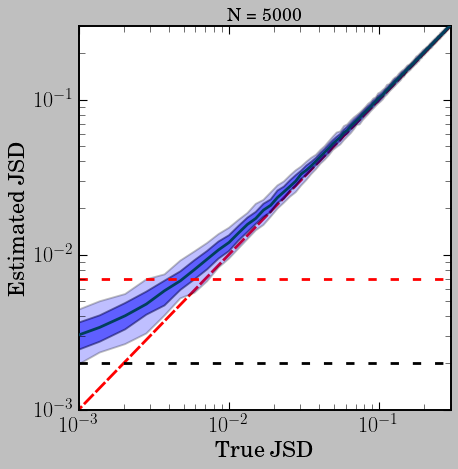

In [61]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 3e-1)
plt.ylim(1e-3, 3e-1)
plt.axhline(2e-3, color='k', ls='--')
plt.axhline(7e-3, color='r', ls='--')
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')